In [1]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from decimal import Decimal, getcontext, ROUND_HALF_UP
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from pylab import*
from scipy.signal import find_peaks
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.path import Path
from matplotlib.patches import PathPatch

In [2]:
def get_triangle(pos_a1, pos_a2, pos_a3):
    
    rel_pos_a1_to_a2 =  pos_a2 - pos_a1
    rel_pos_a1_to_a3 =  pos_a3 - pos_a1
    rel_pos_a2_to_a1 =  pos_a1 - pos_a2
    rel_pos_a2_to_a3 =  pos_a3 - pos_a2
    
    cos_a1 = np.dot(rel_pos_a1_to_a2, rel_pos_a1_to_a3) / (np.linalg.norm(rel_pos_a1_to_a2, ord=2) * np.linalg.norm(rel_pos_a1_to_a3, ord=2))
    cos_a2 = np.dot(rel_pos_a2_to_a1, rel_pos_a2_to_a3) / (np.linalg.norm(rel_pos_a2_to_a1, ord=2) * np.linalg.norm(rel_pos_a2_to_a3, ord=2))

    theta_a1 = np.arccos(cos_a1) * 180 / np.pi
    theta_a2 = np.arccos(cos_a2) * 180 / np.pi
    theta_a3 = 180 - theta_a1 - theta_a2

    return theta_a1, theta_a2, theta_a3


def get_ternary(xs, ys, zs):
    us, vs = [], []
    rt3 = np.sqrt(3)
    for x, y, z in zip(xs, ys, zs):
        u = z + x/2.0
        v = rt3 * x/2.0
        us.append(u); vs.append(v)
    return us, vs


def hexagon_vertices_uv(angle_max=120):
    A = angle_max
    B = 180 - angle_max  # = 60
    candidates = [(A,B,0),(A,0,B),(0,A,B),(B,A,0),(0,B,A),(B,0,A)]
    us, vs = get_ternary([c[0] for c in candidates],
                         [c[1] for c in candidates],
                         [c[2] for c in candidates])
    V = np.array(list(zip(us, vs)))
    cx, cy = V[:,0].mean(), V[:,1].mean()
    order = np.argsort(np.arctan2(V[:,1]-cy, V[:,0]-cx))
    return V[order]

def plot_hexagon(ax, angle_max=120, **kw):
    V = hexagon_vertices_uv(angle_max)
    Vc = np.vstack([V, V[0]])
    if "color" not in kw: kw["color"] = "k"
    ax.plot(Vc[:,0], Vc[:,1], **kw)

def hexagon_path(angle_max=120):
    return Path(hexagon_vertices_uv(angle_max))

def draw_colored_axes(ax, angle_max=120):
    u_min, u_max = 30.0, 150.0
    v_min, v_max = 0.0, 60.0*np.sqrt(3)

    poly = hexagon_path(angle_max)
    clip_patch = PathPatch(poly, transform=ax.transData, facecolor='none', edgecolor='none')
    ax.add_patch(clip_patch)

    col_theta1 = (177/255.0,  24/255.0,  42/255.0)  # 赤
    col_theta2 = (  0/255.0, 129/255.0,   1/255.0)  # 緑
    col_theta3 = ( 31/255.0, 100/255.0, 169/255.0)  # 青

    l1, = ax.plot([90, 90], [v_min, v_max], linestyle=':', linewidth=1.2, color=col_theta1, alpha=0.8)
    vx2, vy2 = (135-0), (45*np.sqrt(3)-0)
    l2, = ax.plot([90 - 2*vx2, 90 + 2*vx2], [30*np.sqrt(3) - 2*vy2, 30*np.sqrt(3) + 2*vy2],
                  linestyle=':', linewidth=1.2, color=col_theta2, alpha=0.8)
    vx3, vy3 = (45-180), (45*np.sqrt(3)-0)
    l3, = ax.plot([90 - 2*vx3, 90 + 2*vx3], [30*np.sqrt(3) - 2*vy3, 30*np.sqrt(3) + 2*vy3],
                  linestyle=':', linewidth=1.2, color=col_theta3, alpha=0.8)
    for ln in (l1, l2, l3):
        ln.set_clip_path(clip_patch)
    

def detect_inflections(theta, variance_ratio=0.02, distance=None):
    
    theta = np.asarray(theta, dtype=float)
    var = float(np.var(theta))
    prom = variance_ratio * var

    peaks, _   = find_peaks(theta,  prominence=prom, distance=distance)
    valleys, _ = find_peaks(-theta, prominence=prom, distance=distance)

    kinds = np.array(['peak']  * len(peaks) + ['valley'] * len(valleys))
    idx   = np.concatenate([peaks, valleys])
    order = np.argsort(idx)
    idx, kinds = idx[order], kinds[order]

    return idx, kinds, peaks, valleys


def build_ref_intervals(infl_idx):
    if len(infl_idx) < 2:
        return np.empty((0,2))
    return np.vstack([infl_idx[:-1], infl_idx[1:]]).T


def phase_from_inflections_at(infl_idx, t):
    prevs = infl_idx[infl_idx <= t]
    nexts = infl_idx[infl_idx >  t]
    if len(prevs)==0 or len(nexts)==0:
        return np.nan
    tk, tk1 = prevs[-1], nexts[0]
    return np.pi * (t - tk) / (tk1 - tk)


def comparator_in_interval(infl_idx_j, tk, tk1):
    inside = infl_idx_j[(infl_idx_j >= tk) & (infl_idx_j < tk1)]
    if len(inside) == 0:
        return 'death', None
    if len(inside) >= 2:
        return 'other', None
    return 'ok', int(inside[0])


def get_labels(ref_intervals_i, kinds_i, infl_idx_j, valleys_j):

    labels_ij = []    
    for i, (tk , tk1) in enumerate(ref_intervals_i):
        status, t_comp = comparator_in_interval(infl_idx_j, tk, tk1)
        if status != 'ok':
            labels_ij.append(status)
            continue

        phi_i = np.pi * (t_comp - tk) / (tk1 - tk)

        if kinds_i[i]=="valley":
            phi_i += np.pi        

        if t_comp in valleys_j:
            phi_j = np.pi
        else:
             phi_j = 0.0

        dphi = np.mod(phi_j - phi_i, 2*np.pi)
        dphi = min(dphi, 2*np.pi - dphi)

        if abs(dphi - 0.0)      <= np.pi/6:   labels_ij.append('inphase')
        elif abs(dphi - np.pi)  <= np.pi/6:   labels_ij.append('antiphase')
        elif abs(dphi - 2*np.pi/3) <= np.pi/6:labels_ij.append('rot120')
        else:                                 labels_ij.append('other')

    return labels_ij


def classify_triplet_patterns(labels_ij, labels_ik):
    triplet_labels = []
    for lab_j, lab_k in zip(labels_ij, labels_ik):

        labs = {lab_j, lab_k}

        if lab_j == 'rot120' and lab_k == 'rot120':
            triplet_labels.append('R')

        elif ('antiphase' in labs) and ('death' in labs):
            triplet_labels.append('PA')

        elif ('inphase' in labs) and ('antiphase' in labs):
            triplet_labels.append('PI')

        elif ('antiphase' in labs) and ('other' in labs):
            triplet_labels.append('PAprime')

        elif ('inphase' in labs) and ('other' in labs):
            triplet_labels.append('PIprime')

        else:
            triplet_labels.append('O')

    return np.array(triplet_labels)


def expand_to_frames(ref_intervals, labels, T):
    out = np.array(['O']*T, dtype=object)
    for (tk, tk1), lab in zip(ref_intervals, labels):
        tk = int(max(0, tk))
        tk1 = int(min(T, tk1))
        if tk1 > tk:
            out[tk:tk1] = lab
    return out


PRIORITY = {'R':5, 'PA':4, 'PI':3, 'PAprime':2, 'PIprime':1, 'O':0}

def combine_frames(fr1, fr2, fr3):
    T = len(fr1)
    comb = np.empty(T, dtype=object)
    for t in range(T):
        cands = [fr1[t], fr2[t], fr3[t]]
        # 最も優先度が高いものを採用
        comb[t] = max(cands, key=lambda x: PRIORITY.get(x, 0))
    return comb


ALL_LABELS = ['R','PA','PI','PAprime','PIprime','O']

def get_ratios(R_frames, PA_frames, PI_frames, PAprime_frames, PIprime_frames, O_frames):
    
    R = np.sum(R_frames)
    PA = np.sum(PA_frames)
    PI = np.sum(PI_frames)
    PAprime = np.sum(PAprime_frames)
    PIprime = np.sum(PIprime_frames)
    O = np.sum(O_frames)
    
    ALL = R + PA + PI + PAprime + PIprime + O
    
    ratios = {
        'R': R / ALL,
        'PA': PA / ALL,
        'PI': PI / ALL,
        'PAprime': PAprime / ALL,
        'PIprime': PIprime / ALL,
        'O': O / ALL,
    }
    
    return ratios


def frame_counts_and_ratios(frames):
    T = len(frames)
    cnt = Counter(frames)
    counts = {lab: float(cnt.get(lab, 0.0)) for lab in ALL_LABELS}
    if T > 0:
        ratios = {lab: counts[lab] / T for lab in ALL_LABELS}
    else:
        ratios = {lab: 0.0 for lab in ALL_LABELS}
    return counts, ratios

# Fig. 4b,c

In [3]:
# alphabets = list("ABCDEFGHI") 
alphabets = list("E") 

for alphabet in alphabets:
    fig = plt.figure(figsize=(30, 20))
    print('----', alphabet, '----')

    for sub_num in range(28):
        sub = f"{sub_num+1:03d}"
        ax = fig.add_subplot(4, 7, sub_num + 1)

        theta_a1, theta_a2, theta_a3 = [], [], []

        for con_num in range(3):
            condition = alphabet + str(con_num + 1)
            load_name = f"../data/sub/sub{sub}/sub{sub}_{condition}.npy"
            pos_list = np.load(load_name, allow_pickle=True)

            for episode in range(8):
                pos_episode = pos_list[episode]
                a1_pos = np.array(pos_episode[1])
                a2_pos = np.array(pos_episode[2])
                a3_pos = np.array(pos_episode[3])

                for i in range(len(a1_pos)):
                    t1, t2, t3 = get_triangle(a1_pos[i], a2_pos[i], a3_pos[i])
                    theta_a1.append(t1); theta_a2.append(t2); theta_a3.append(t3)

        us, vs = get_ternary(theta_a1, theta_a2, theta_a3)
        u_min, u_max = 30.0, 150.0
        v_min, v_max = 0.0, 60.0*np.sqrt(3)

        d = 3
        bins = int(120 / d)
        H, xedges, yedges = np.histogram2d(us, vs, bins=bins,
                                           range=[[u_min, u_max], [v_min, v_max]])
        xcenters = (xedges[:-1] + xedges[1:]) / 2
        ycenters = (yedges[:-1] + yedges[1:]) / 2
        X, Y = np.meshgrid(xcenters, ycenters)
        poly = hexagon_path(120)
        inside = poly.contains_points(np.c_[X.ravel(), Y.ravel()]).reshape(Y.shape)
        H_masked = np.where(inside, H.T, 0.0)
        plot_hexagon(ax, angle_max=120, color='k')
        draw_colored_axes(ax, angle_max=120)
        cf = ax.contour(X, Y, H_masked, levels=100, cmap='RdBu_r')
        fig.colorbar(cf, ax=ax)
        ax.set_aspect('equal')
        ax.set_xlim(u_min, u_max)
        ax.set_ylim(v_min, v_max)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


---- E ----


# Fig. 4d-f

50
---- E ----


45
---- E ----


40
---- E ----


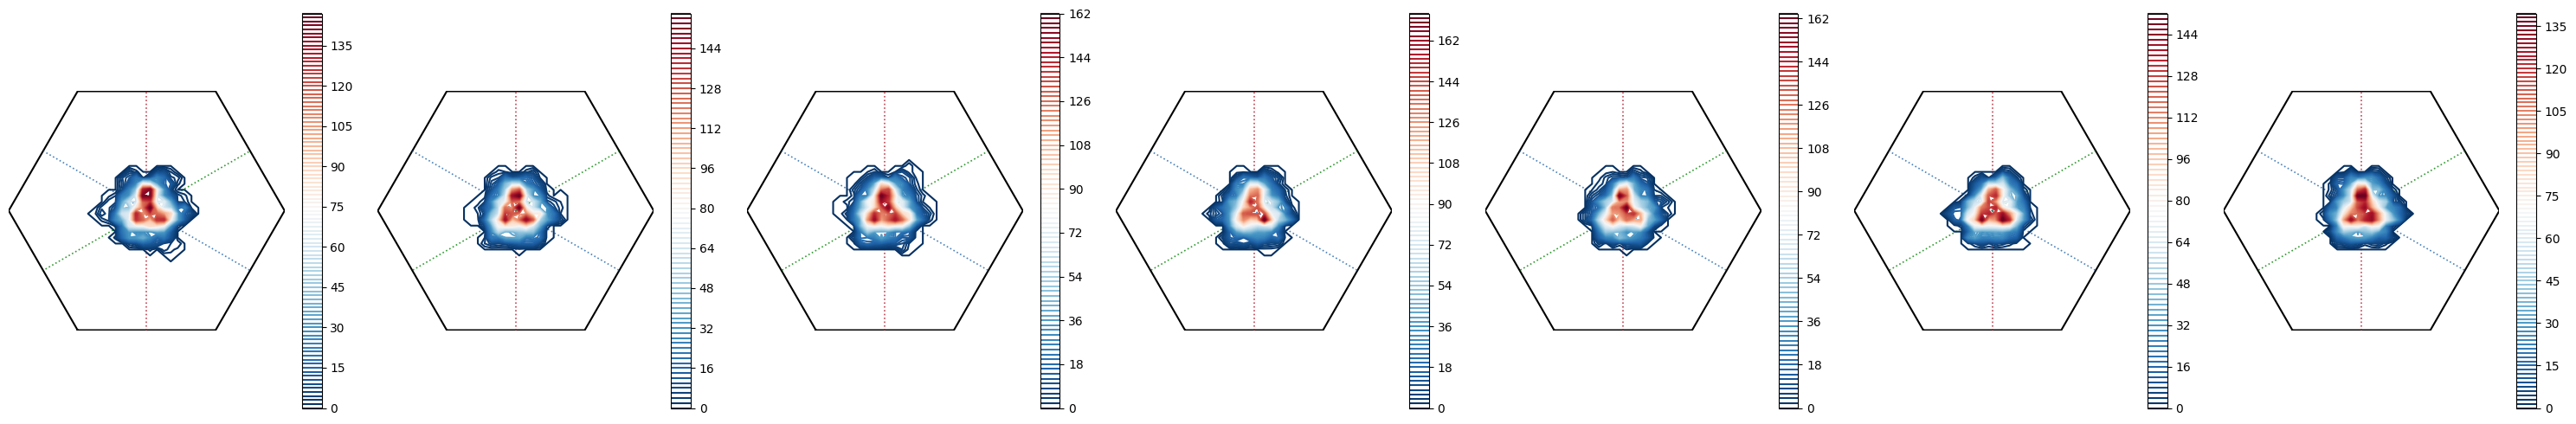

35
---- E ----


30
---- E ----


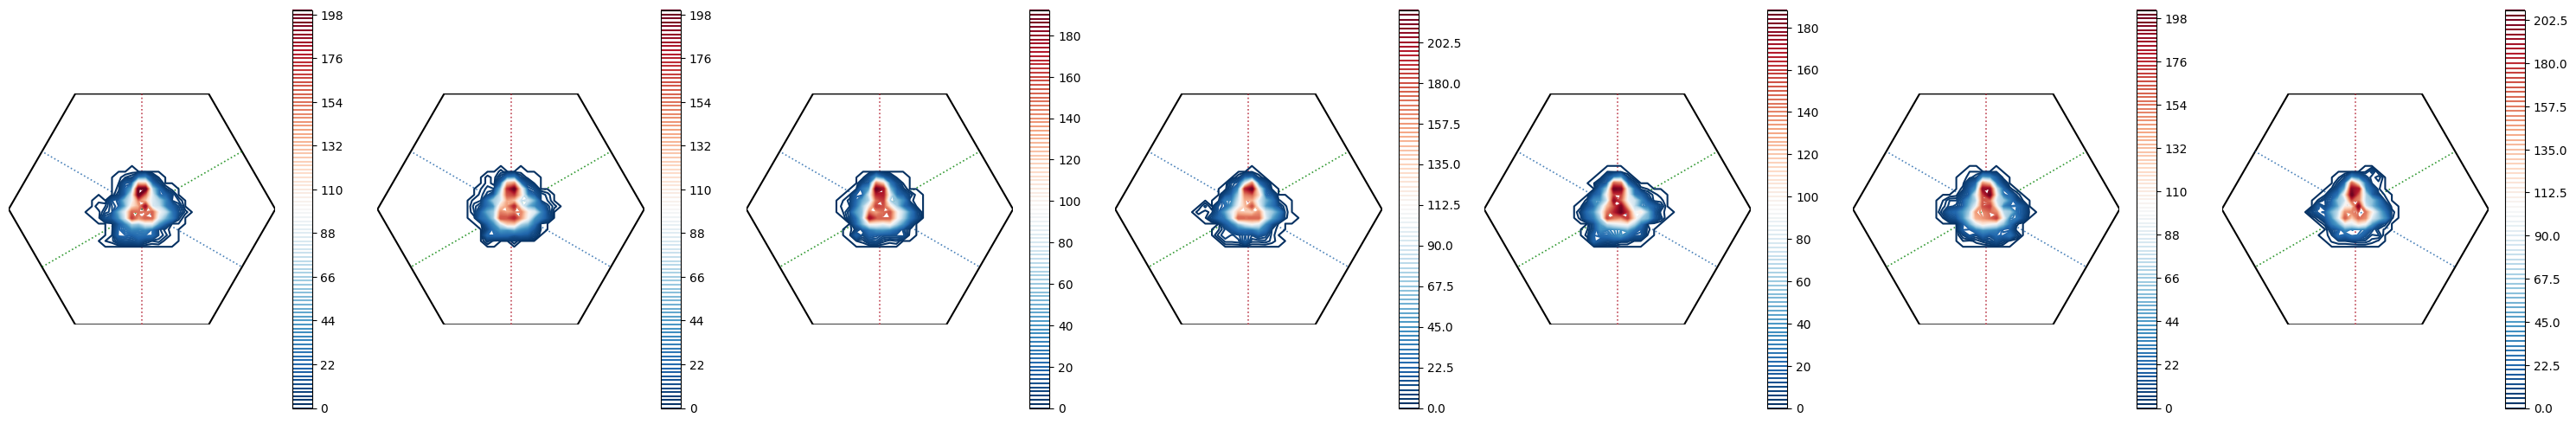

25
---- E ----


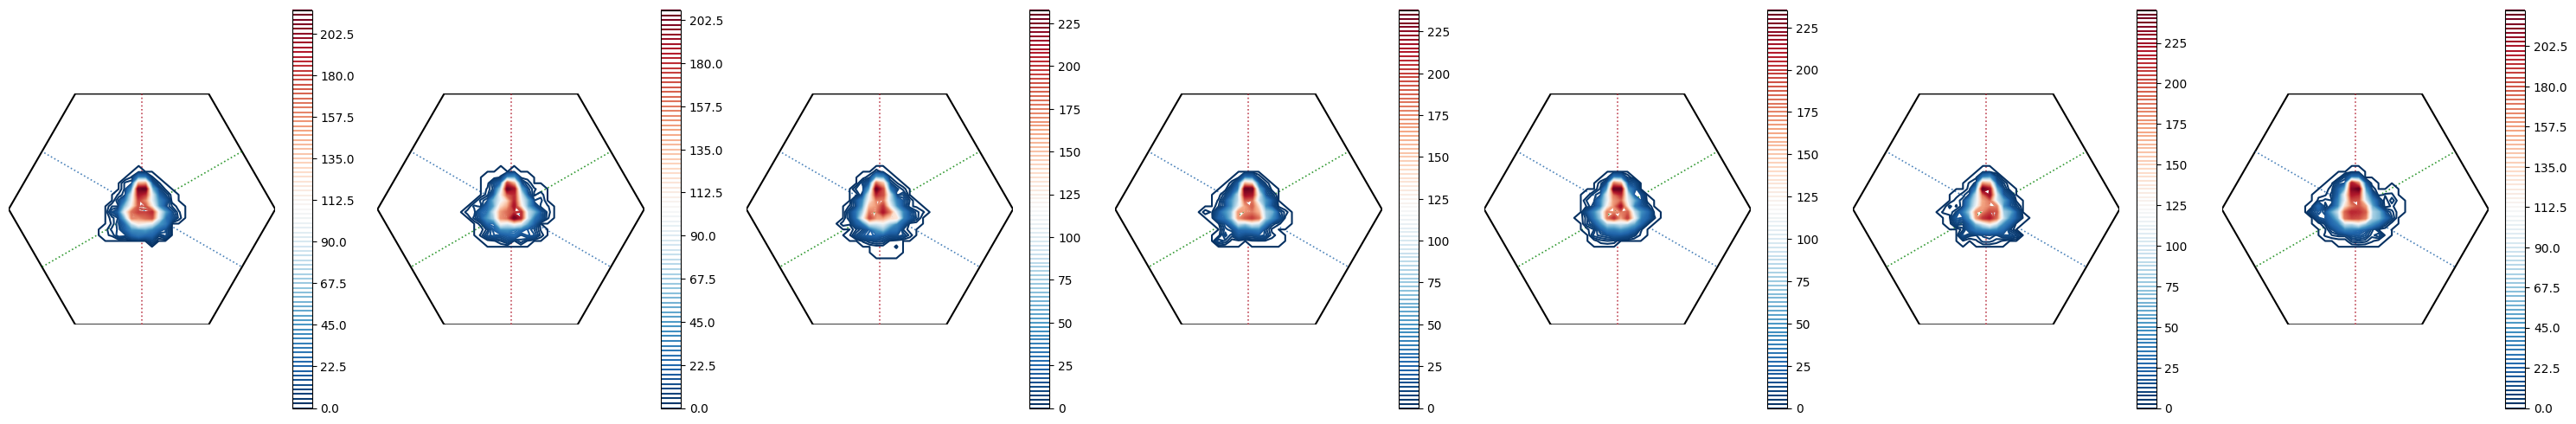

20
---- E ----


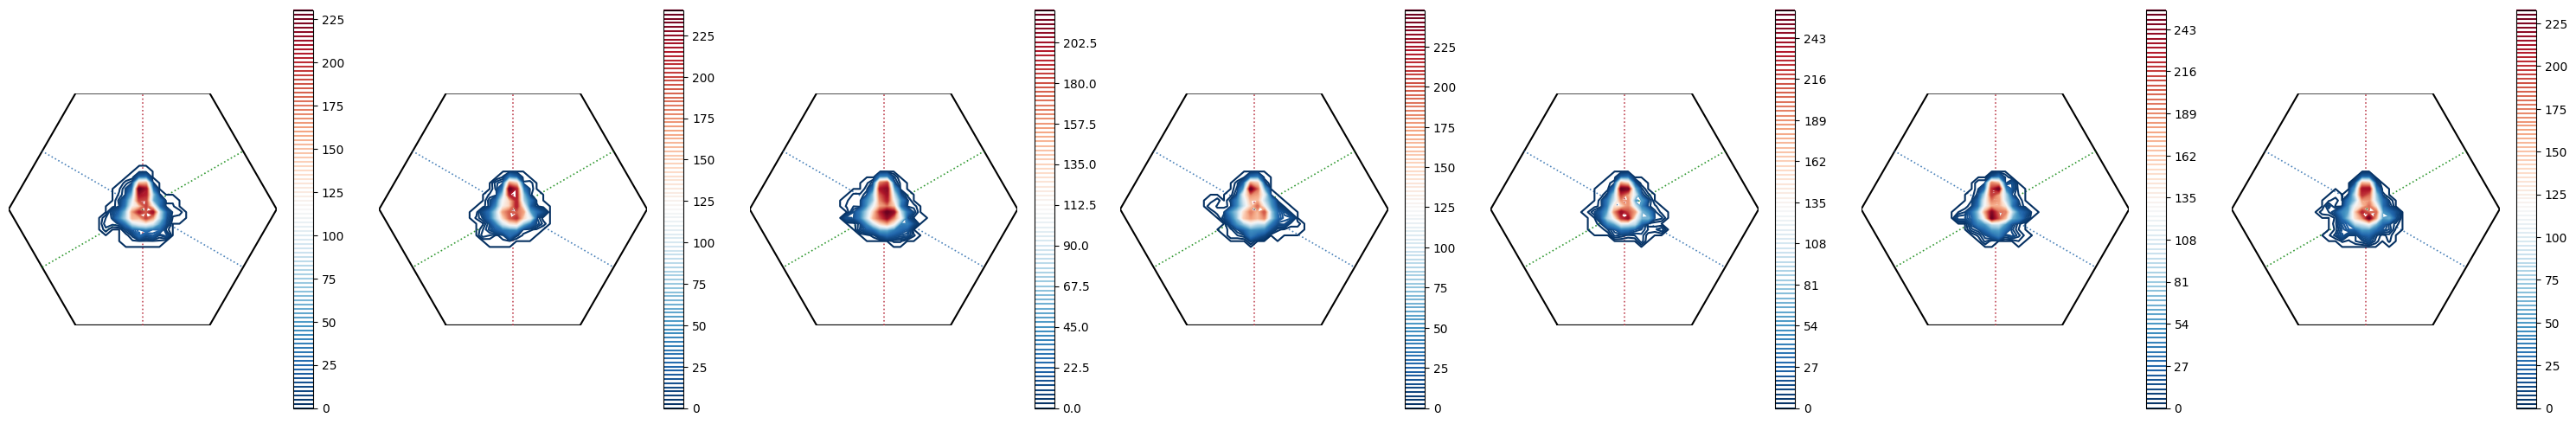

15
---- E ----


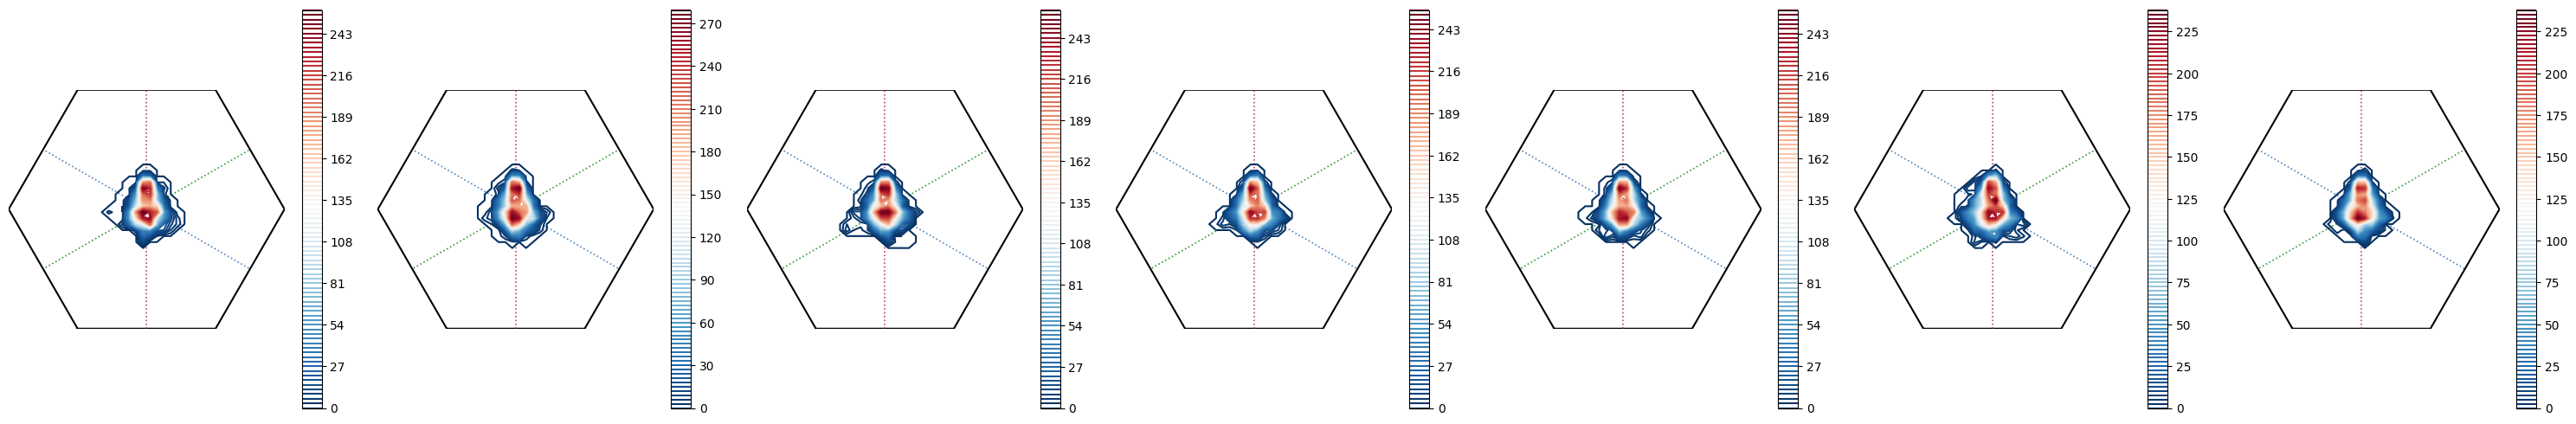

10
---- E ----


5
---- E ----


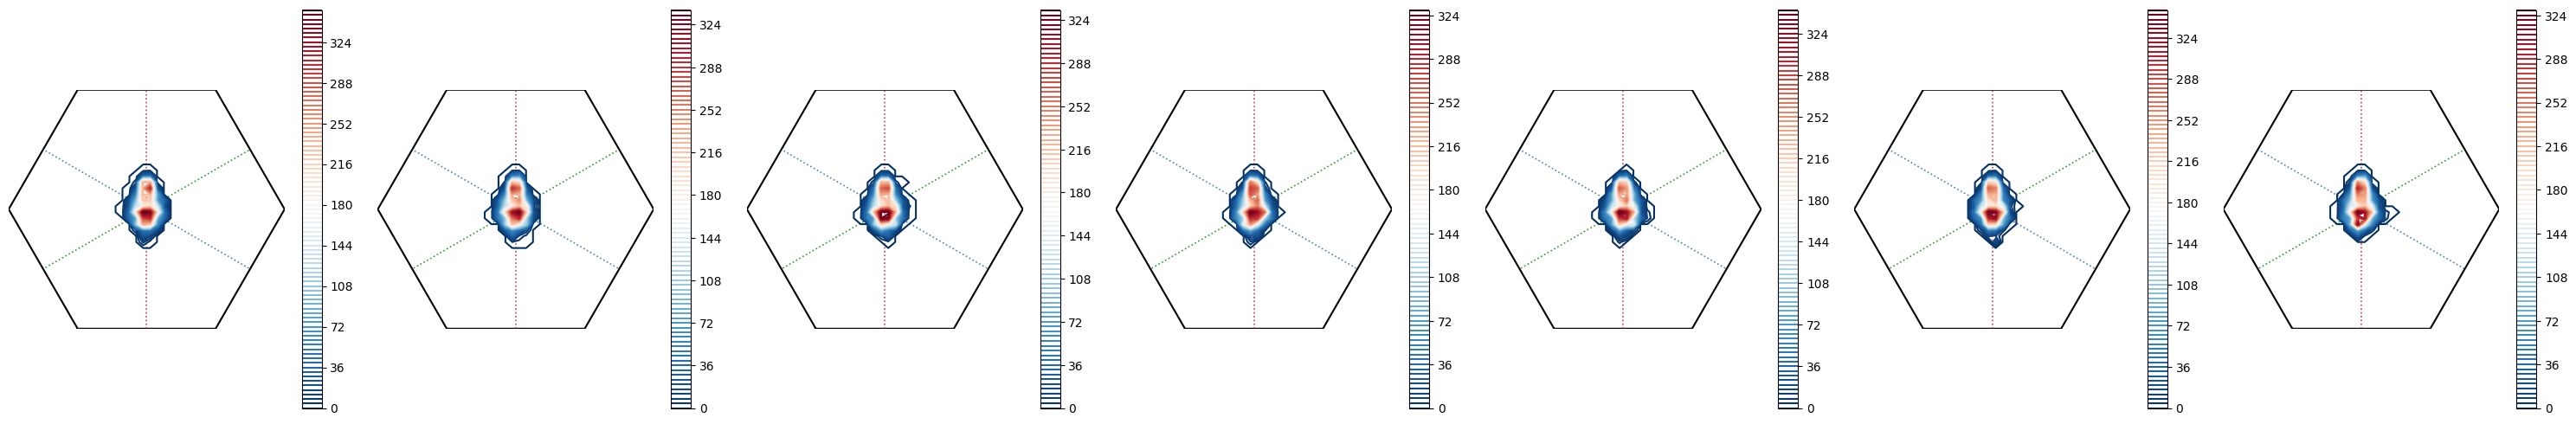

0
---- E ----


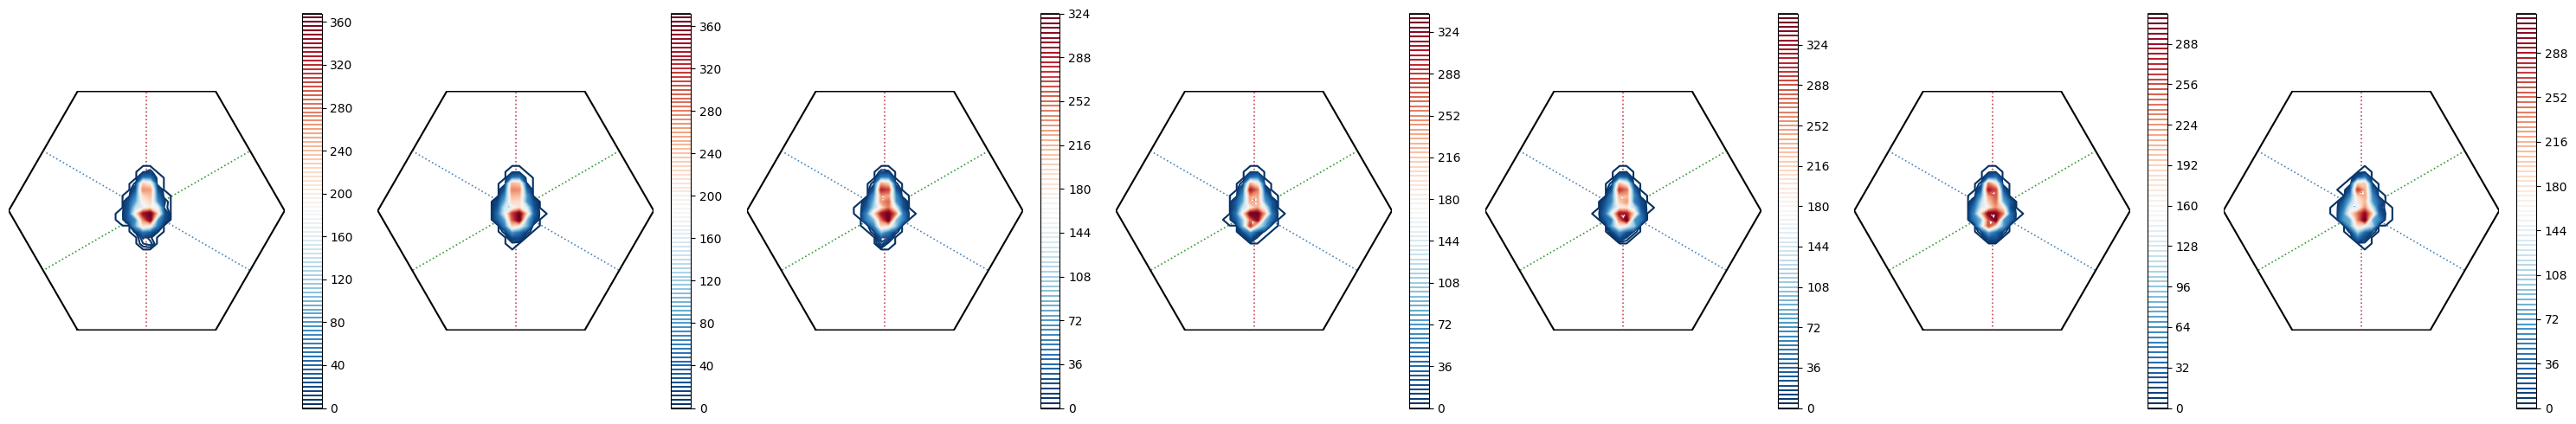

In [4]:
threshold_max_list = [50, 45, 40, 35, 30, 25, 20, 15, 10, 5, 0]

for threshold_max in threshold_max_list:
    print(threshold_max)

    for alphabet in alphabets:
        fig = plt.figure(figsize=(30, 5))
        print('----', alphabet, '----')

        for sub_num in range(7):
            sub = f"{sub_num+1:03d}"
            ax = fig.add_subplot(1, 7, sub_num + 1)

            theta_a1, theta_a2, theta_a3 = [], [], []

            for con_num in range(3):
                condition = alphabet + str(con_num + 1)
                
                load_name = f"../data/agent/max_sigma/max_{threshold_max}/sigma_0/agent{sub}/agent{sub}_{condition}.npy"
                pos_list = np.load(load_name, allow_pickle=True)

                for episode in range(8):
                    pos_episode = pos_list[episode]
                    a1_pos = np.array(pos_episode[1])
                    a2_pos = np.array(pos_episode[2])
                    a3_pos = np.array(pos_episode[3])

                    for i in range(len(a1_pos)):
                        t1, t2, t3 = get_triangle(a1_pos[i], a2_pos[i], a3_pos[i])
                        theta_a1.append(t1); theta_a2.append(t2); theta_a3.append(t3)

            us, vs = get_ternary(theta_a1, theta_a2, theta_a3)
            u_min, u_max = 30.0, 150.0
            v_min, v_max = 0.0, 60.0*np.sqrt(3)

            d = 3
            bins = int(120 / d)
            H, xedges, yedges = np.histogram2d(us, vs, bins=bins,
                                               range=[[u_min, u_max], [v_min, v_max]])
            xcenters = (xedges[:-1] + xedges[1:]) / 2
            ycenters = (yedges[:-1] + yedges[1:]) / 2
            X, Y = np.meshgrid(xcenters, ycenters)
            poly = hexagon_path(120)
            inside = poly.contains_points(np.c_[X.ravel(), Y.ravel()]).reshape(Y.shape)
            H_masked = np.where(inside, H.T, 0.0)
            plot_hexagon(ax, angle_max=120, color='k')
            draw_colored_axes(ax, angle_max=120)
            cf = ax.contour(X, Y, H_masked, levels=100, cmap='RdBu_r')
            fig.colorbar(cf, ax=ax)
            ax.set_aspect('equal')
            ax.set_xlim(u_min, u_max)
            ax.set_ylim(v_min, v_max)
            ax.axis('off')

        plt.tight_layout()
        plt.show()


# Fig. 4j

In [5]:
alphabets = list("ABCDEFGHI")  # A〜I
max_theta_list = [50, 45, 40, 35, 30, 25, 20, 15, 10, 5, 0]

all_pattern_ratios_alhabet = []
for max_theta in max_theta_list:
    print("======== max_theta", max_theta, "========")

    pattern_ratios_alhabet = []
    for alphabet in alphabets:
        con_alphabet = alphabet

        pattern_ratios_sub = []
        for sub_num in range(28):
            sub = '{0:03d}'.format(sub_num + 1)

            R_frames = []
            PA_frames = []
            PI_frames = []
            PAprime_frames = []
            PIprime_frames = []
            O_frames = []
            for con_num in range(3):
                condition = con_alphabet + str(con_num + 1)
                load_name = f"../data/agent/max_sigma/max_{max_theta}/sigma_0/agent" + sub + "/agent" + sub + "_" + condition + ".npy"
                pos_list = np.load(load_name, allow_pickle=True)

                for episode in range(8):
                    pos_episode = pos_list[episode]
                    defender_pos_episode = pos_episode[0]
                    attacker1_pos_episode = pos_episode[1]
                    attacker2_pos_episode = pos_episode[2]
                    attacker3_pos_episode = pos_episode[3]

                    theta_a1, theta_a2, theta_a3 = [], [], []
                    n_steps = len(attacker1_pos_episode)

                    for i in range(n_steps):
                        th1, th2, th3 = get_triangle(np.array(attacker1_pos_episode)[i], np.array(attacker2_pos_episode)[i], np.array(attacker3_pos_episode)[i])
                        theta_a1.append(th1)
                        theta_a2.append(th2)
                        theta_a3.append(th3)

                    theta_a1 = np.array(theta_a1)
                    theta_a2 = np.array(theta_a2)
                    theta_a3 = np.array(theta_a3)

                    infl_idx1, kinds1, peaks1, valleys1 = detect_inflections(theta_a1)
                    infl_idx2, kinds2, peaks2, valleys2 = detect_inflections(theta_a2)
                    infl_idx3, kinds3, peaks3, valleys3 = detect_inflections(theta_a3)

                    ref_intervals1 = build_ref_intervals(infl_idx1)
                    ref_intervals2 = build_ref_intervals(infl_idx2)
                    ref_intervals3 = build_ref_intervals(infl_idx3)

                    labels_ij1 = get_labels(ref_intervals1, kinds1, infl_idx2, valleys2)
                    labels_ik1 = get_labels(ref_intervals1, kinds1, infl_idx3, valleys3)
                    triplet_labels1 = classify_triplet_patterns(labels_ij1, labels_ik1)

                    labels_ij2 = get_labels(ref_intervals2, kinds2, infl_idx1, valleys1)
                    labels_ik2 = get_labels(ref_intervals2, kinds2, infl_idx3, valleys3)
                    triplet_labels2 = classify_triplet_patterns(labels_ij2, labels_ik2)

                    labels_ij3 = get_labels(ref_intervals3, kinds3, infl_idx1, valleys1)
                    labels_ik3 = get_labels(ref_intervals3, kinds3, infl_idx2, valleys2)
                    triplet_labels3 = classify_triplet_patterns(labels_ij3, labels_ik3)

                    T = len(theta_a1)
                    fr1 = expand_to_frames(ref_intervals1, triplet_labels1, T)
                    fr2 = expand_to_frames(ref_intervals2, triplet_labels2, T)
                    fr3 = expand_to_frames(ref_intervals3, triplet_labels3, T)

                    fused = combine_frames(fr1, fr2, fr3)
                    counts, ratios = frame_counts_and_ratios(fused)

                    R_frames.append(counts['R'])
                    PA_frames.append(counts['PA'])
                    PI_frames.append(counts['PI'])
                    PAprime_frames.append(counts['PAprime'])
                    PIprime_frames.append(counts['PIprime'])
                    O_frames.append(counts['O'])

            pattern_ratios = get_ratios(R_frames, PA_frames, PI_frames, PAprime_frames, PIprime_frames, O_frames)
            pattern_ratios_sub.append(pattern_ratios)

        pattern_ratios_alhabet.append(pattern_ratios_sub)
        
    all_pattern_ratios_alhabet.append(pattern_ratios_alhabet)



======== max_theta 50 ========
======== max_theta 45 ========
======== max_theta 40 ========
======== max_theta 35 ========
======== max_theta 30 ========
======== max_theta 25 ========
======== max_theta 20 ========
======== max_theta 15 ========
======== max_theta 10 ========
======== max_theta 5 ========
======== max_theta 0 ========


In [6]:

all_rs = []
all_pas = []
all_pis = []
all_paps = []
all_pips = []
all_os = []

for k in range(11):

    param_rs = []
    param_pas = []
    param_pis = []
    param_paps = []
    param_pips = []
    param_os = []
    for j in range(9):
        
        rs = []
        pas = []
        pis = []
        paps = []
        pips = []
        os = []
        for i in range(28):
            r = all_pattern_ratios_alhabet[k][j][i]['R']
            pa = all_pattern_ratios_alhabet[k][j][i]['PA']
            pi = all_pattern_ratios_alhabet[k][j][i]['PI']
            pap = all_pattern_ratios_alhabet[k][j][i]['PAprime']
            pip = all_pattern_ratios_alhabet[k][j][i]['PIprime']
            o = all_pattern_ratios_alhabet[k][j][i]['O']

            rs.append(r)    
            pas.append(pa)
            pis.append(pi)
            pips.append(pap)    
            paps.append(pip)
            os.append(o)

        param_rs.append(rs)
        param_pas.append(pas)
        param_pis.append(pis)
        param_paps.append(paps)
        param_pips.append(pips)
        param_os.append(os)

    all_rs.append(param_rs)
    all_pas.append(param_pas)
    all_pis.append(param_pis)
    all_paps.append(param_paps)
    all_pips.append(param_pips)
    all_os.append(param_os)
    

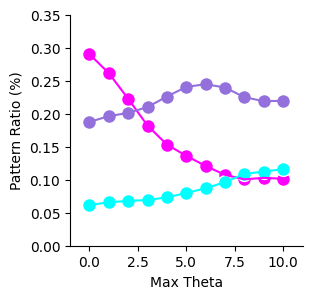

In [7]:
import sys, os

mean_R_agent = np.array(all_rs).mean(axis=2).mean(axis=1)
mean_PA_agent = np.array(all_pas).mean(axis=2).mean(axis=1)
mean_PI_agent = np.array(all_pis).mean(axis=2).mean(axis=1)
mean_PAprime_agent = np.array(all_paps).mean(axis=2).mean(axis=1)
mean_PIprime_agent = np.array(all_pips).mean(axis=2).mean(axis=1)
mean_O_agent = np.array(all_os).mean(axis=2).mean(axis=1)
    
point_size = 100
xs = range(11)
fig, ax = plt.subplots(figsize=(3, 3))

plt.plot(mean_R_agent, color="magenta", alpha=1)
plt.plot(mean_PA_agent, color="mediumpurple", alpha=1)
plt.plot(mean_PI_agent, color="cyan", alpha=1)

ax.scatter(xs, mean_R_agent, color='magenta', edgecolor='white', s=point_size, zorder=1, alpha=1)
ax.scatter(xs, mean_PA_agent, color='mediumpurple', edgecolor='white', s=point_size, zorder=1, alpha=1)
ax.scatter(xs, mean_PI_agent, color='cyan', edgecolor='white', s=point_size, zorder=1, alpha=1)

ax.set_xlabel("Max Theta")
ax.set_ylabel("Pattern Ratio (%)")
ax.set_xlim(-1, 11)
ax.set_ylim(0, 0.35)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width, box.height])
[ax.spines[side].set_visible(False) for side in ['right', 'top']]

plt.show()
